## [ 필요한 패키지 설치 ]

In [1]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install beautifulsoup4
!pip install urllib3
!pip install scipy
!pip install statsmodels
!pip install scikit-learn

## 1. 사용할 모듈 import

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import urllib.request
import re

from scipy import stats
from scipy.stats import levene, ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings(action='ignore')

---
## 2. 데이터셋 로드 / 전처리

#### 2-1. 프로젝트 주제에 대한 초기 데이터셋 불러오기

In [3]:
fc_df = pd.read_csv("fake_currency_data.csv")

# 데이터 가공 전 초기 상태 출력
print(fc_df.info())
fc_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Country           1000000 non-null  object 
 1   Denomination      1000000 non-null  object 
 2   Counterfeit       1000000 non-null  int64  
 3   SerialNumber      1000000 non-null  int64  
 4   SecurityFeatures  1000000 non-null  object 
 5   Weight            1000000 non-null  float64
 6   Length            1000000 non-null  float64
 7   Width             1000000 non-null  float64
 8   Thickness         1000000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 68.7+ MB
None


,Country,Denomination,Counterfeit,SerialNumber,SecurityFeatures,Weight,Length,Width,Thickness
0,USA,$100,1,25973198,Hologram,1.731759,130.243185,66.537999,0.098488
1,USA,$20,1,95903230,Security Thread,1.002179,152.596364,76.135834,0.094119
2,EU,€10,0,82937914,Hologram,2.306713,152.857126,66.772442,0.061393
3,USA,€20,1,23612989,Microprint,1.366965,143.133672,78.377052,0.053114
4,EU,€20,1,56025342,Watermark,1.796075,129.664777,75.916093,0.051438
...,...,...,...,...,...,...,...,...,...
999995,EU,$100,1,24436622,Watermark,1.472511,134.888731,75.425943,0.093939
999996,EU,£20,1,82654212,Hologram,2.355633,147.830149,65.232274,0.097358
999997,USA,$5,0,59174754,Microprint,1.393764,150.050308,69.273269,0.068363
999998,EU,£10,0,55268089,Watermark,2.026417,142.852137,77.878841,0.081160


### => 결측치(NaN)가 존재하지 않음!

#### 2-2. 크롤링을 활용한 데이터 증강

In [4]:
# 국가별 통화 사용 정보를 크롤링해 '유용성' feature로 활용
currency_url = "https://www.iban.kr/currency-codes"
currency_html = urllib.request.urlopen(currency_url)
currency_soup = BeautifulSoup(currency_html, "html.parser")

# 크롤링을 위해 중간결과 출력
print(currency_soup.prettify())

<!DOCTYPE html>
<!--[if IE 8 ]><html class="ie" xmlns="http://www.w3.org/1999/xhtml" xml:lang="ko" lang="ko"> <![endif]-->
<!--[if (gte IE 9)|!(IE)]><!-->
<html lang="ko" xml:lang="ko" xmlns="http://www.w3.org/1999/xhtml">
 <!--<![endif]-->
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <!--[if IE]><meta http-equiv='X-UA-Compatible' content='IE=edge,chrome=1'><![endif]-->
  <title>
   국가별 통화 코드 목록 (ISO 4217)
  </title>
  <meta content="통화명 목록이 업데이트되었습니다. 각 국가의 영문자 3자 및 숫자 3자 ISO 4217 코드입니다." name="description"/>
  <meta content="목록, 통화, 통화 코드, ISO 4217, 국제 통화, 활성 코드" name="keywords"/>
  <meta content="#153570" name="theme-color"/>
  <meta content="#153570" name="apple-mobile-web-app-status-bar-style"/>
  <meta content="width" name="MobileOptimized">
   <meta content="true" name="HandheldFriendly">
    <meta content="width=device-width, initial-scale=1" name="viewport"/>
    <link href="https://www.iban.kr/currency-codes" rel="canonical"/>
    <link hre

In [5]:
# 크롤링을 통해 원하는 데이터 추출
# Target : 국가별 통화 사용 정보

# 통화 사용 데이터를 담을 리스트
coun_List = []
curr_List = []

# 태그를 활용해 크롤링
tbody = currency_soup.find("tbody")
td = tbody.find_all("td")

# 전체 데이터 = 4개의 <td>로 구성
# 첫 번째 정보: Country, 두 번째 정보: Target
for i in range(int(len(td) / 4)) :
  # 두 데이터를 리스트에 추가하기
  coun_List.append(td[4*i])
  curr_List.append(td[4*i + 1])

# 리스트 내 요소들을 cleaned-text화 시키기
def clean_strip(text) :
  text = str(text)
  clean_text = text.replace("<td>", "").replace("</td>", "")
  clean_strip_text = clean_text.strip()
  return clean_strip_text
coun_List = [clean_strip(string) for string in coun_List]
curr_List = [clean_strip(string) for string in curr_List]

# 분석 및 가공을 위해 DataFrame로 변환
curr_df = pd.DataFrame({"Country": coun_List, "Currency": curr_List})
curr_df

,Country,Currency
0,아프가니스탄,아프가니
1,올란드 제도,유로
2,알바니아,렉
3,알제리,알제리 디나르
4,미국령 사모아,미국 달러
...,...,...
263,월리스푸투나제도,CFP 프랑
264,서사하라,모로칸 디르함
265,예멘,예멘리알
266,잠비아,잠비아 크와차


In [6]:
# 국가별 GDP 정보를 크롤링해 '유용성' feature로 활용
gdp_url = "https://www.worldometers.info/gdp/gdp-by-country/"
gdp_html = urllib.request.urlopen(gdp_url)
gdp_soup = BeautifulSoup(gdp_html, "html.parser")

# 크롤링을 위해 중간결과 출력
print(gdp_soup.prettify())

<!DOCTYPE html>
<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if !IE]><!-->
<html lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   GDP by Country - Worldometer
  </title>
  <meta content="Countries in the world ranked by Gross Domestic Product (GDP). List and ranking of GDP growth, GDP per capita and couuntry share of World's GDP" name="description"/>
  <!-- Favicon -->
  <link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link href="/favicon/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
  <link href="/favicon/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
  <link href="/favicon/apple-icon-76x76.png" rel="apple-touch-icon" 

In [7]:
# 국가별 GDP 데이터를 담을 리스트
coun_List = []
gdp_List = []

# 태그를 활용해 크롤링
tbody = gdp_soup.find("tbody")
country = tbody.find_all("td", style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px")
gdp = tbody.find_all("td", style="font-weight: bold; text-align:right;")

# 국가, GDP 정보 추출해 DataFrame 생성하기
for i in range(len(country)) :
  # 두 개의 데이터 정보를 각 리스트에 추가
  coun_List.append(country[i])
  gdp_List.append(gdp[6 * i]) # gdp 정보는 6개로 구성됨, Target: 첫 번째

# 리스트 내 요소들을 cleaned-text화 시키기
def gdp_clean_strip(text) :
  text = str(text)
  
  # 데이터 종료에 따라 분기
  if "<td style=\"font-weight: bold; text-align:right;\">" in text :
    text = text.replace("<td style=\"font-weight: bold; text-align:right;\">", "")
  elif "<td style=\"font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px\">" in text :
    text = text.replace("<td style=\"font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px\">", "")
    text = re.sub(r"<a\s[^>]*>|</a>", "", text) # 정규식 활용
  
  # clean + strip
  clean_text = text.replace("</td>", "")
  clean_strip_text = clean_text.strip()
  return clean_strip_text

coun_List = [gdp_clean_strip(string) for string in coun_List]
gdp_List = [gdp_clean_strip(string) for string in gdp_List]

# 분석 및 가공을 위해 DataFrame로 변환
gdp_df = pd.DataFrame({"Country": coun_List, "GDP": gdp_List})
gdp_df

,Country,GDP
0,United States,"$25,462,700,000,000"
1,China,"$17,963,200,000,000"
2,Japan,"$4,231,140,000,000"
3,Germany,"$4,072,190,000,000"
4,India,"$3,385,090,000,000"
...,...,...
172,Sao Tome &amp; Principe,"$546,680,342"
173,Micronesia,"$427,094,119"
174,Marshall Islands,"$279,667,900"
175,Kiribati,"$223,352,943"


In [8]:
# '미국 달러'를 사용하는 나라 조회
curr_df[curr_df["Currency"] == '미국 달러']

,Country,Currency
4,미국령 사모아,미국 달러
29,"보나이러, 세인트 유스타티유스 및 사바섬",미국 달러
34,영국령 인도양 지역 (THE),미국 달러
69,에콰도르,미국 달러
72,엘살바도르,미국 달러
96,괌,미국 달러
103,아이티,미국 달러
148,마셜제도 (THE),미국 달러
156,미크로네시아,미국 달러
177,북마리아나제도 (THE),미국 달러


In [9]:
# '유로'를 사용하는 나라 조회
curr_df[curr_df["Currency"] == '유로']

,Country,Currency
1,올란드 제도,유로
5,안도라,유로
14,오스트리아,유로
21,벨기에,유로
63,키프로스,유로
75,에스토니아,유로
77,유럽연합,유로
81,핀란드,유로
82,프랑스,유로
83,프랑스령 기아나,유로


In [10]:
# '파운드스털링'을 사용하는 나라 조회
curr_df[curr_df["Currency"] == '파운드스털링']

,Country,Currency
98,건지,파운드스털링
116,맨섬,파운드스털링
121,제르제,파운드스털링
251,영국 (THE),파운드스털링


In [11]:
# 각 통화별 사용국 리스트
use_dollar = ['United States', 'Ecuador', 'El Salvador', 'Haiti', 'Marshall Islands', 'Micronesia', 'Panama', 'Samoa', 'Timor-Leste']
use_euro = ['Andorra', 'Austrialia', 'Belgium', 'Cyprus', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy',
            'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Portugal', 'Slovakia', 'Slovenia', 'Spain']
use_pound = ['United Kingdom']

# 각 통화별 사용국 정보를 활용해 총 GDP를 계산
def gdp_preprocess(x) :
  x = x[1:]
  x = x.replace(",", "")
  return int(x)
gdp_df['GDP'] = gdp_df['GDP'].apply(gdp_preprocess)

# 'Dollar' GDP 총합
dollar_df = gdp_df[gdp_df['Country'].isin(use_dollar)]
dollar_sum_gdp = dollar_df.GDP.sum()
# 'Euro' GDP 총합
euro_df = gdp_df[gdp_df['Country'].isin(use_euro)]
euro_sum_gdp = euro_df.GDP.sum()
# 'Pound' GDP 총합
pound_df = gdp_df[gdp_df['Country'].isin(use_pound)]
pound_sum_gdp = pound_df.GDP.sum()

# 세 값을 정규화
def gdp_standardize(x) :
  return x / 10000000000000
gdp_List = [dollar_sum_gdp, euro_sum_gdp, pound_sum_gdp]
for i in range(3) :
  gdp_List[i] = gdp_standardize(gdp_List[i])
  
# 활용할 계수 출력
print("Dollar Usage:", gdp_List[0])
print("Euro Usage:", gdp_List[1])
print("Pound Usage:", gdp_List[2])

Dollar Usage: 2.5711716291881
Euro Usage: 1.3578943939257
Pound Usage: 0.307067


#### 2-3. 데이터 가공 및 크롤링으로부터 얻은 데이터 활용

In [12]:
# 1. 'Country' 데이터와 'Denomination' 데이터 중 단위 feature를 합성
fc_df['Src_Dest'] = fc_df['Country'] + '_' + fc_df['Denomination'].apply(lambda x : x[0])

# 2. 크롤링 결과 데이터를 활용해 새로운 feature 생성
def denomTousage(denom) :
  if denom[0] == '$' :
    usage = gdp_List[0]
  elif denom[0] == '€' :
    usage = gdp_List[1]
  else :
    usage = gdp_List[2]
  return usage
fc_df['Usage'] = fc_df['Denomination'].apply(denomTousage)

# 3. SerialNumber는 큰 의미를 가지지 않는 컬럼이므로 삭제
fc_df = fc_df.drop(columns=['SerialNumber'])

# 4. SecurityFeature을 바탕으로 AI/non-AI feature를 구분하는 컬럼 생성
def securityToAI(security) :
  if security in ["Hologram", "Security Thread"] :
    ai = 0
  else :
    ai = 1
  return ai
fc_df['AI'] = fc_df['SecurityFeatures'].apply(securityToAI)

# 5. Length, Width 데이터를 곱해서 축약 => '면적'
fc_df['Area'] = fc_df['Length'] * fc_df['Width']
fc_df = fc_df.drop(columns=['Length', 'Width']) # 활용한 컬럼은 drop

# 6. Weight, Area, Thickness를 활용해 새로운 feature 생성 -> '밀도'
fc_df['Density'] = fc_df['Weight'] / fc_df['Area']
fc_df

,Country,Denomination,Counterfeit,SecurityFeatures,Weight,Thickness,Src_Dest,Usage,AI,Area,Density
0,USA,$100,1,Hologram,1.731759,0.098488,USA_$,2.571172,0,8666.120975,0.000200
1,USA,$20,1,Security Thread,1.002179,0.094119,USA_$,2.571172,0,11618.051441,0.000086
2,EU,€10,0,Hologram,2.306713,0.061393,EU_€,1.357894,0,10206.643517,0.000226
3,USA,€20,1,Microprint,1.366965,0.053114,USA_€,1.357894,1,11218.395270,0.000122
4,EU,€20,1,Watermark,1.796075,0.051438,EU_€,1.357894,1,9843.643273,0.000182
...,...,...,...,...,...,...,...,...,...,...,...
999995,EU,$100,1,Watermark,1.472511,0.093939,EU_$,2.571172,1,10174.109805,0.000145
999996,EU,£20,1,Hologram,2.355633,0.097358,EU_£,0.307067,0,9643.296759,0.000244
999997,USA,$5,0,Microprint,1.393764,0.068363,USA_$,2.571172,1,10394.475278,0.000134
999998,EU,£10,0,Watermark,2.026417,0.081160,EU_£,0.307067,1,11125.158811,0.000182


#### 2-4. 수치 데이터들의 Outlier에 대한 처리

< Outlier 처리 전 Numeric 데이터 분포 >


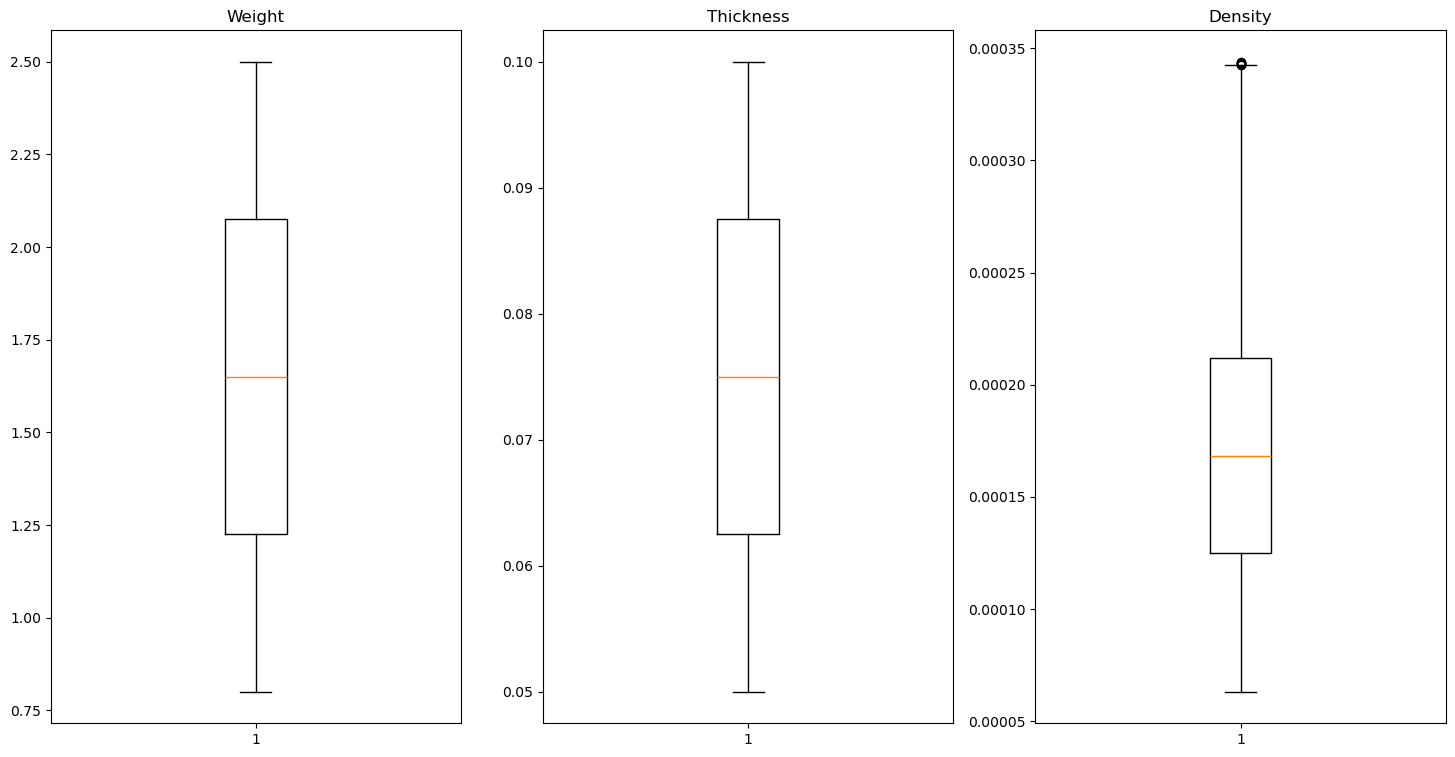

In [13]:
# Numeric 데이터들을 box plotting하는 메서드
def plot_box(numeric_df) :
  # Subplot 활용
  cols = numeric_df.columns
  n_cols = len(cols)
  n_fig = 1
  n_axes = n_cols // n_fig + (n_cols % n_fig > 0)
  
  # 각 컬럼에 대해 plotting
  fig, axes = plt.subplots(n_fig, n_axes, figsize=(18, 9))
  for i in range(n_cols) :
    col = i % n_axes
    axes[col].boxplot(numeric_df[cols[i]])
    axes[col].set_title(cols[i])
  plt.show()
  
# Numeric 데이터만을 활용해 이상치 처리 전 분포 그리기
numeric_df = fc_df[['Weight', 'Thickness', 'Density']]
print("< Outlier 처리 전 Numeric 데이터 분포 >")
plot_box(numeric_df)

< Outlier 처리 후 Numeric 데이터 분포 >


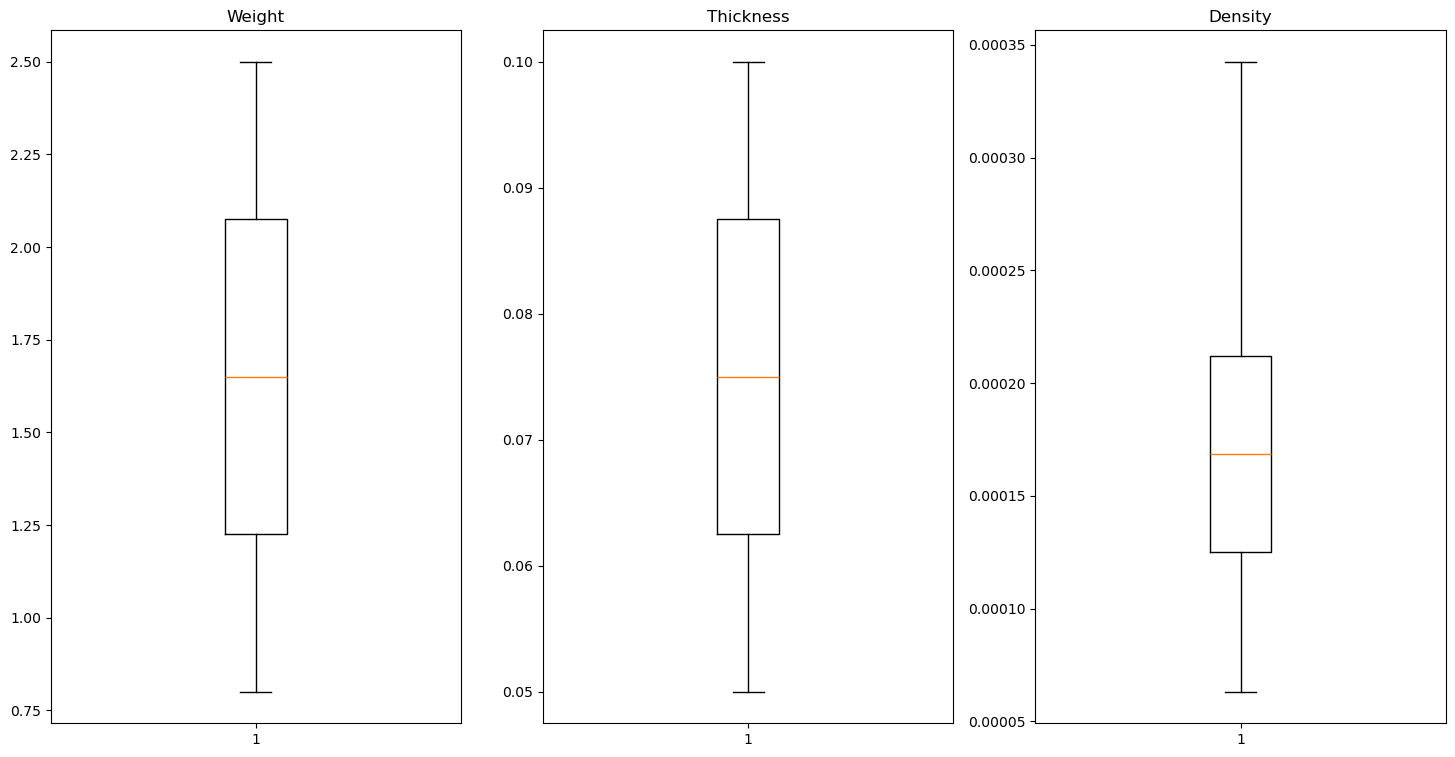

In [14]:
# Outlier에 대해 상/하단 처리하는 메서드
def handle_outlier(numerics) :
  # 수치형 데이터의 Outlier 판별하기
  Q1 = numerics.quantile(0.25)
  Q3 = numerics.quantile(0.75)
  IQR = Q3 - Q1
  
  # Outlier 경계 설정
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR
  
  # 상/하단 처리
  numerics[numerics > upper_whisker] = numerics.quantile(0.99)
  numerics[numerics < lower_whisker] = numerics.quantile(0.01)
  
# 해당하는 컬럼에 대해 메서드 적용
for col in numeric_df.columns :
  handle_outlier(numeric_df[col])
  
print("< Outlier 처리 후 Numeric 데이터 분포 >")
plot_box(numeric_df)

#### 2-5. 데이터셋 로드 / 전처리의 결과

In [15]:
# 데이터셋 로드 및 전처리의 최종 결과 출력하기

# Outlier 처리 적용
fc_df[['Weight', 'Thickness', 'Density']] = numeric_df

# 데이터프레임 재배열
fc_df = fc_df.reindex(columns=['Country', 'Denomination', 'Src_Dest', 'Usage', 'SecurityFeatures',
                              'AI', 'Weight', 'Area', 'Thickness', 'Density', 'Counterfeit'])
fc_df

,Country,Denomination,Src_Dest,Usage,SecurityFeatures,AI,Weight,Area,Thickness,Density,Counterfeit
0,USA,$100,USA_$,2.571172,Hologram,0,1.731759,8666.120975,0.098488,0.000200,1
1,USA,$20,USA_$,2.571172,Security Thread,0,1.002179,11618.051441,0.094119,0.000086,1
2,EU,€10,EU_€,1.357894,Hologram,0,2.306713,10206.643517,0.061393,0.000226,0
3,USA,€20,USA_€,1.357894,Microprint,1,1.366965,11218.395270,0.053114,0.000122,1
4,EU,€20,EU_€,1.357894,Watermark,1,1.796075,9843.643273,0.051438,0.000182,1
...,...,...,...,...,...,...,...,...,...,...,...
999995,EU,$100,EU_$,2.571172,Watermark,1,1.472511,10174.109805,0.093939,0.000145,1
999996,EU,£20,EU_£,0.307067,Hologram,0,2.355633,9643.296759,0.097358,0.000244,1
999997,USA,$5,USA_$,2.571172,Microprint,1,1.393764,10394.475278,0.068363,0.000134,0
999998,EU,£10,EU_£,0.307067,Watermark,1,2.026417,11125.158811,0.081160,0.000182,0


---
## 3. 2개의 변수 간의 관계 분석

#### 3-1. ( 독립변수 - 종속변수 )의 관계가 'Nominal - Nominal'인 경우
#### => 교차 분석 (Chisq)

In [16]:
# 교차분석(Chisq)을 위한 시각화/결과 출력 함수를 정의
def do_chisq(var1, var2, threshold) :
  # normFlag에 따라 분기
  # 시각화 -> bar() or pie()
  if threshold == True :
    ct = pd.crosstab(var1, var2)
    ct.plot.bar(stacked=True)
  else :
    ct = pd.crosstab(var2, var1)
    ct.plot.pie(subplots=True)
  plt.show()
    
  # '차이'의 통계적 유의성, pvalue 확인하기
  print(stats.chi2_contingency(ct))
  
  return

# 독립변수 및 종속변수 정의하기
indpdt_var = ['Country', 'Denomination', 'Src_Dest', 'Usage', 'SecurityFeatures', 'AI'] # 독립변수들 중 Nominal인 것들
dpdt_var = fc_df['Counterfeit']

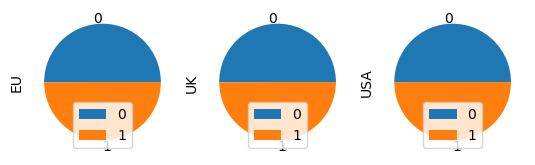

Chi2ContingencyResult(statistic=0.3709933745642375, pvalue=0.83069158742324, dof=2, expected_freq=array([[166728.328059, 167008.669099, 166872.002842],
       [166322.671941, 166602.330901, 166465.997158]]))


In [17]:
# 1. Country - Counterfeit 관계
do_chisq(fc_df[indpdt_var[0]], dpdt_var, False)

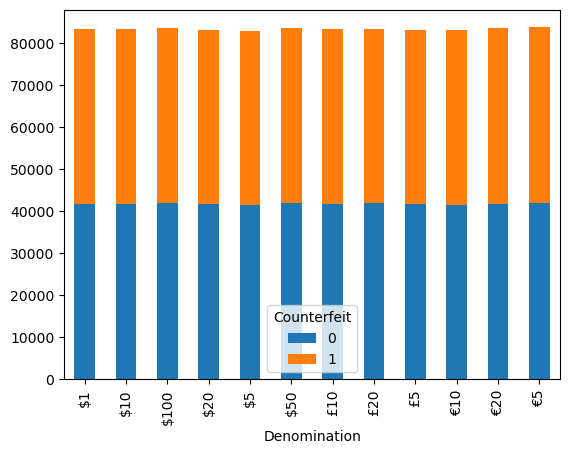

Chi2ContingencyResult(statistic=5.279106128382365, pvalue=0.9168996758935495, dof=11, expected_freq=array([[41723.757714, 41622.242286],
       [41666.688288, 41565.311712],
       [41856.919708, 41755.080292],
       [41581.084149, 41479.915851],
       [41484.466612, 41383.533388],
       [41847.408137, 41745.591863],
       [41766.810088, 41665.189912],
       [41671.694378, 41570.305622],
       [41646.663928, 41545.336072],
       [41630.143831, 41528.856169],
       [41797.847846, 41696.152154],
       [41935.515321, 41833.484679]]))


In [18]:
# 2. Denomination - Counterfeit 관계
do_chisq(fc_df[indpdt_var[1]], dpdt_var, True)

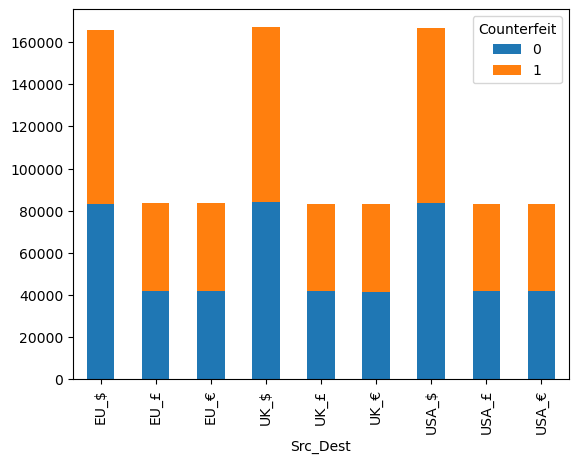

Chi2ContingencyResult(statistic=6.18790781256554, pvalue=0.6261924455962169, dof=8, expected_freq=array([[82987.956366, 82786.043634],
       [41811.864898, 41710.135102],
       [41928.506795, 41826.493205],
       [83688.308357, 83484.691643],
       [41597.604246, 41496.395754],
       [41722.756496, 41621.243504],
       [83484.059885, 83280.940115],
       [41675.69925 , 41574.30075 ],
       [41712.243707, 41610.756293]]))


In [19]:
# 3. Src_Dest - Counterfeit 관계
do_chisq(fc_df[indpdt_var[2]], dpdt_var, True)

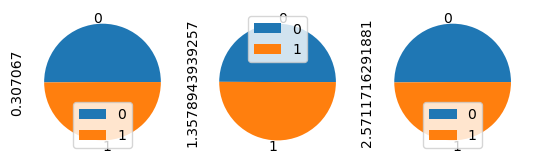

Chi2ContingencyResult(statistic=2.1483126210954295, pvalue=0.3415858261212984, dof=2, expected_freq=array([[125085.168394, 125363.506998, 250160.324608],
       [124780.831606, 125058.493002, 249551.675392]]))


In [20]:
# 4. Usage - Counterfeit 관계
do_chisq(fc_df[indpdt_var[3]], dpdt_var, False)

Counterfeit            0       1
SecurityFeatures                
Hologram          125441  124605
Microprint        124853  125512
Security Thread   125490  124718
Watermark         124825  124556


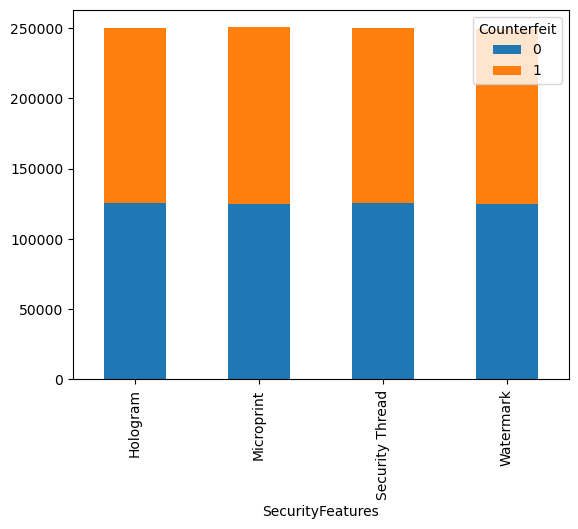

Chi2ContingencyResult(statistic=5.718262343069301, pvalue=0.12615153094203646, dof=3, expected_freq=array([[125175.278014, 124870.721986],
       [125334.972285, 125030.027715],
       [125256.376672, 124951.623328],
       [124842.373029, 124538.626971]]))


In [21]:
# 5. SecurityFeatures - Counterfeit 관계
print(pd.crosstab(fc_df[indpdt_var[4]], dpdt_var))
do_chisq(fc_df[indpdt_var[4]], dpdt_var, True)

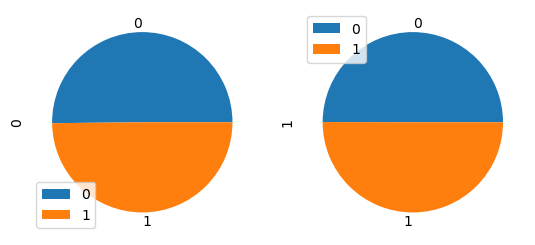

Chi2ContingencyResult(statistic=3.981553291020136, pvalue=0.046001124317232266, dof=1, expected_freq=array([[250431.654686, 250177.345314],
       [249822.345314, 249568.654686]]))


In [22]:
# 6. AI - Counterfeit 관계
do_chisq(fc_df[indpdt_var[5]], dpdt_var, False)

### [분석 결과]
##### 카이 제곱 검정 결과, 종속변수에 대한 6개의 Nominal 독립변수 각각의 통계 결과는 다음과 같다.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Country - Counterfeit) 관계 : pvalue=0.83069158742324
##### &nbsp;&nbsp;&nbsp;(Denomination - Counterfeit) 관계 : pvalue=0.9168996758935495
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Src_Dest - Counterfeit) 관계 : pvalue=0.6261924455962169
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Usage - Counterfeit) 관계 : pvalue=0.3415858261212984
##### (SecurityFeatures - Counterfeit) 관계 : pvalue=0.12615153094203646
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(AI - Counterfeit) 관계 : pvalue=0.046001124317232266

##### 일반적으로 통계적 유의성을 구분하기 위한 pvalue의 기준값으로 0.05가 활용되는데,
##### 따라서 AI feature(비물리적 보안기술) 와의 관계만 유일하게 통계적 의미를 가진다고 할 수 있다.
##### 그러나 Usage(유용성), SecurityFeatures(보안 기술) 및 기준을 좀 rough하게 잡으면
##### Src_Dest feature까지도 활용 가능성이 있는 pvalue값을 가진다고 할 수 있다.

---
#### *3-1. 부가적인 관계 추적 (Nominal - Nominal)
#### => Country(발행된 국가)와 SecurityFeatures

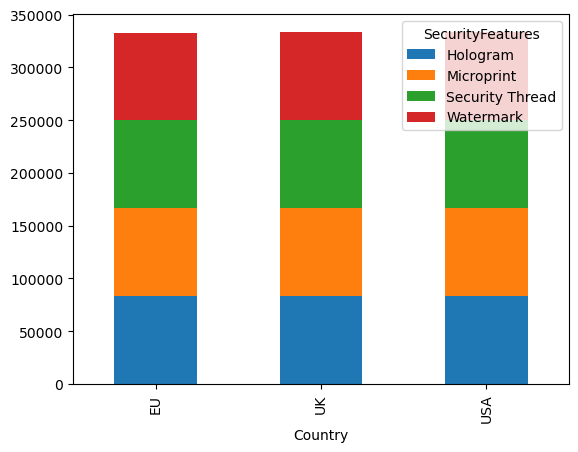

Chi2ContingencyResult(statistic=7.859714423586228, pvalue=0.24856224613595915, dof=6, expected_freq=array([[83278.070346, 83384.313615, 83332.024608, 83056.591431],
       [83418.096106, 83524.518015, 83472.141088, 83196.244791],
       [83349.833548, 83456.16837 , 83403.834304, 83128.163778]]))


In [23]:
# 6. Src_Dest - SecurityFeatures 관계
do_chisq(fc_df[indpdt_var[0]], fc_df[indpdt_var[4]], True)

##### 기준 pvalue 값에는 미치지 못하지만, '발행된 국가'에 따른 '보안 기술'은
##### 통계적으로 어느 정도의 유의미한 차이를 가진다고 할 수 있다.

---
#### 3-2. ( 독립변수 - 종속변수 )의 관계가 'Numeric - Nominal'인 경우
#### => 평균 비교 (T-test)

In [24]:
# 평균 비교(T-test)를 위한 시각화/결과 출력 함수를 정의
def do_ttest(df, num, nom, val1, val2) :
  # 시각화 -> boxplot
  sns.boxplot(data=df, x=nom, y=num)
  plt.show()
  
  # 각 집단 정의
  group1 = df[df[nom] == val1]
  group2 = df[df[nom] == val2]
  
  # 먼저, 등분산성 검사 수행
  statistic, p_value = levene(group1[num], group2[num])
  
  # 위 결과값 : pvalue에 따라 분기
  # '차이'의 통계적 유의성, pvalue 확인하기
  if p_value < 0.05 :
    print(ttest_ind(group1[num], group2[num], equal_var=False))
  else :
    print(ttest_ind(group1[num], group2[num], equal_var=True))
  
  return

# 독립변수 정의하기
numeric_var = ['Weight', 'Area', 'Thickness', 'Density'] # 독립변수들 중 Numeric인 것들

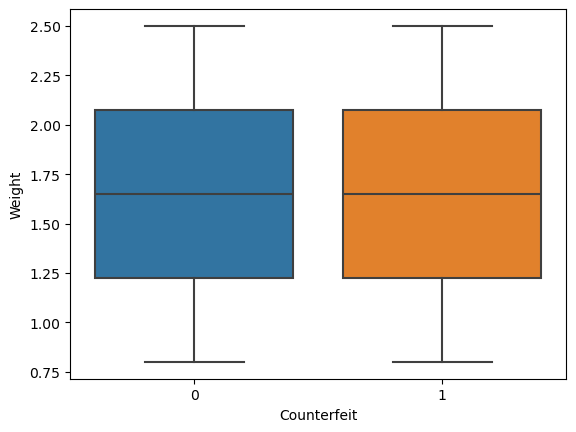

TtestResult(statistic=0.4901497876069732, pvalue=0.6240280168429981, df=999998.0)


In [25]:
# 1. Weight - Counterfeit 관계
do_ttest(fc_df, numeric_var[0], "Counterfeit", 0, 1)

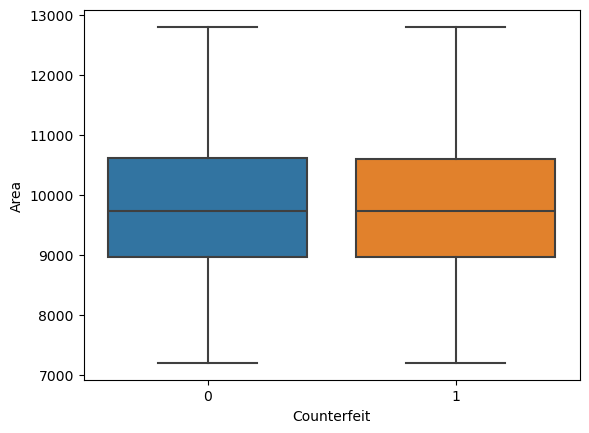

TtestResult(statistic=0.7024442497346604, pvalue=0.4824023213985752, df=999996.8548940176)


In [26]:
# 2. Area - Counterfeit 관계
do_ttest(fc_df, numeric_var[1], "Counterfeit", 0, 1)

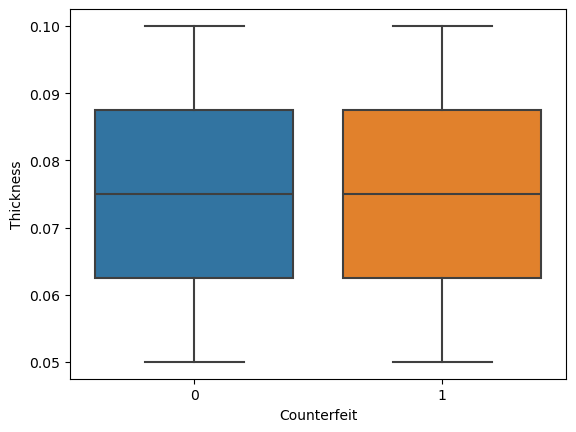

TtestResult(statistic=-0.4892581304867737, pvalue=0.6246590667473766, df=999998.0)


In [27]:
# 3. Thickness - Counterfeit 관계
do_ttest(fc_df, numeric_var[2], "Counterfeit", 0, 1)

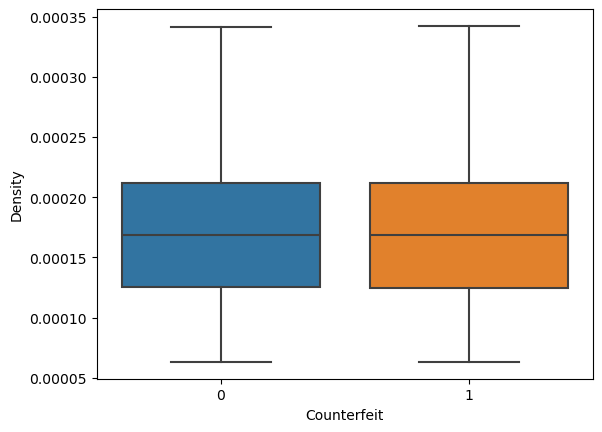

TtestResult(statistic=0.31398289801397355, pvalue=0.7535340933271407, df=999998.0)


In [28]:
# 4. Density - Counterfeit 관계
do_ttest(fc_df, numeric_var[3], "Counterfeit", 0, 1)

### [분석 결과]
##### T-test 검정 결과, 종속변수에 대한 4개의 Numeric 독립변수 각각의 통계 결과는 다음과 같다.
##### &nbsp;&nbsp;&nbsp;&nbsp;(Weight - Counterfeit) 관계 : pvalue=0.6240280168429981
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Area - Counterfeit) 관계 : pvalue=0.4824023213985752
##### (Thickness - Counterfeit) 관계 : pvalue=0.6246590667473766
##### &nbsp;&nbsp;&nbsp;(Density - Counterfeit) 관계 : pvalue=0.7535340933271407

##### 4개의 Numeric 독립 변수에 대한 결과 모두 pvalue의 기준값에 미치지 못함
##### 다만, Numeric 독립 변수들을 대상으로 대략적인 유의성 순위는 파악할 수 있다.
##### < Feature Selection 시 참고 가능 > : 1. Area(면적) 2. Weight(무게), Thickness(두께) 3. Density(밀도)

---
#### *3-2. 부가적인 관계 추적 (Numeric - Nominal)
#### => 크롤링을 통해 얻은 feature인 Usage(유용성)을 Numeric으로 적용해본다면?

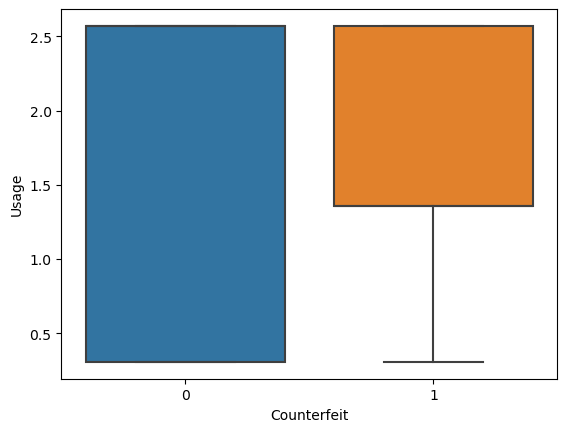

TtestResult(statistic=0.3176930565436579, pvalue=0.7507178449802911, df=999998.0)


In [29]:
# Usage - Counterfeit 관계
do_ttest(fc_df, "Usage", "Counterfeit", 0, 1)

### [결론]
##### 'Usage' feature를 Nominal로 가정했을 때보다 좋지 못한 통계가 나오므로,
##### 해당 feature가 가지고 있는 정량적인 속성을 제거하고 Ordinal로 변환하는 작업이 가능하다.

#### => 값이 3가지 이상인 독립변수 : ANOVA

In [30]:
# ANOVA 분석을 위한 메서드 정의
def do_anova(df, num, nom) :
  # 시각화 -> boxplot
  sns.boxplot(data=df, x=nom, y=num)
  plt.show()
  
  # ANOVA 모델 생성
  model = ols(num + '~' + nom, df).fit()
  
  # 결과 출력
  print(anova_lm(model))
  
  return

# 독립변수 및 종속변수 정의하기
indpdt = 'SecurityFeatures'
dpdt_List = ['Weight', 'Area', 'Thickness', 'Density']

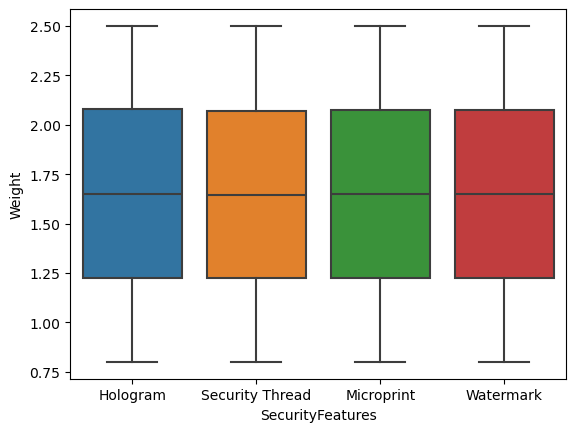

                        df        sum_sq   mean_sq         F    PR(>F)
SecurityFeatures       3.0       0.69293  0.230977  0.959213  0.410879
Residual          999996.0  240797.30592  0.240798       NaN       NaN


In [31]:
# 1. SecurityFeatures와 Weight(무게)
do_anova(fc_df, dpdt_List[0], indpdt)

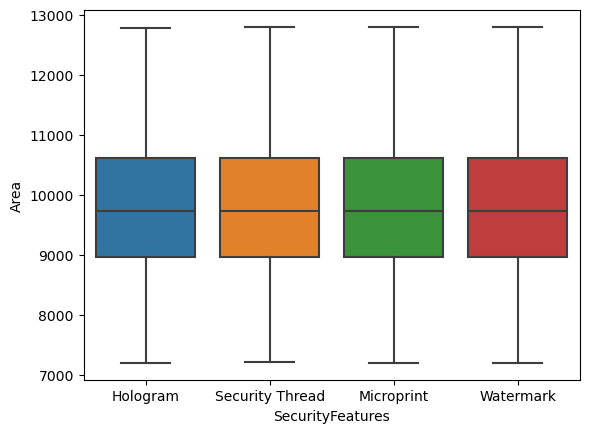

                        df        sum_sq       mean_sq         F    PR(>F)
SecurityFeatures       3.0  1.058411e+06  3.528037e+05  0.269153  0.847682
Residual          999996.0  1.310788e+12  1.310793e+06       NaN       NaN


In [32]:
# 2. SecurityFeatures와 Area(면적)
do_anova(fc_df, dpdt_List[1], indpdt)

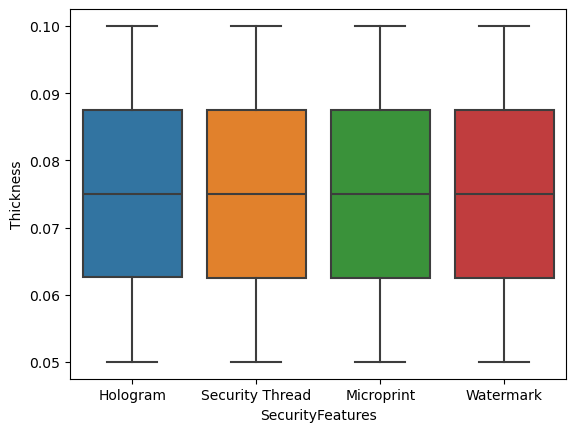

                        df      sum_sq   mean_sq         F    PR(>F)
SecurityFeatures       3.0    0.000283  0.000094  0.452524  0.715509
Residual          999996.0  208.560044  0.000209       NaN       NaN


In [33]:
# 3. SecurityFeatures와 Thickness(두께)
do_anova(fc_df, dpdt_List[2], indpdt)

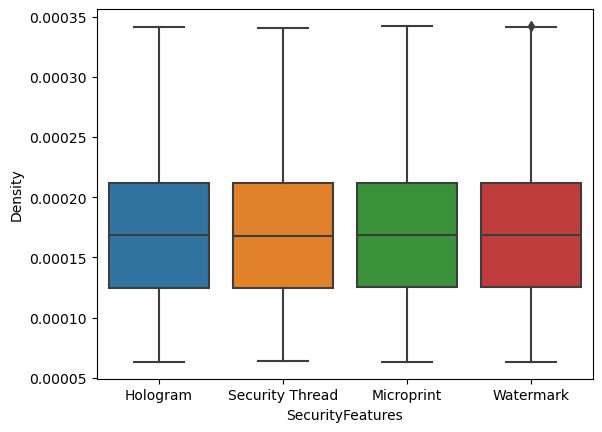

                        df        sum_sq       mean_sq         F    PR(>F)
SecurityFeatures       3.0  1.111663e-08  3.705544e-09  1.229536  0.297112
Residual          999996.0  3.013763e-03  3.013775e-09       NaN       NaN


In [34]:
# 4. SecurityFeatures와 Density(밀도)
do_anova(fc_df, dpdt_List[3], indpdt)

### [분석 결과]
##### 부가적인 관계들에 대한 ANOVA 검정 통계 결과는 다음과 같다.
##### &nbsp;&nbsp;&nbsp;&nbsp;(SecurityFeatures - Weight) 관계 : pvalue=0.410879
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(SecurityFeatures - Area) 관계 : pvalue=0.847682
##### (SecurityFeatures - Thickness) 관계 : pvalue=0.715509
##### &nbsp;&nbsp;&nbsp;(SecurityFeatures - Density) 관계 : pvalue=0.297112

##### 4개의 통계 결과 모두 유의미한 pvalue 값을 가지진 못했지만,
##### SecurityFeatures(보안 기술)은 지폐의 물리적 특성 중 Density(밀도)에 가장 많은 영향을 준다는 사실은 알 수 있다.

---
## 4. 현재까지의 분석 결과를 활용해 직접 모델에 적용해보기
#### Original Dataset + Feature-handled(분석 적용된) Dataset

#### 4-1. 각 데이터셋을 준비

In [35]:
og_df = pd.read_csv("fake_currency_data.csv")

# SerialNumber 컬럼 삭제
og_df = og_df.drop(columns=['SerialNumber'])

# 컬럼들을 보기 편하게 재정렬
og_df = og_df.reindex(columns=['Country', 'Denomination', 'SecurityFeatures',
                              'Weight', 'Length', 'Width', 'Thickness', 'Counterfeit'])

# Original Dataset
og_df

,Country,Denomination,SecurityFeatures,Weight,Length,Width,Thickness,Counterfeit
0,USA,$100,Hologram,1.731759,130.243185,66.537999,0.098488,1
1,USA,$20,Security Thread,1.002179,152.596364,76.135834,0.094119,1
2,EU,€10,Hologram,2.306713,152.857126,66.772442,0.061393,0
3,USA,€20,Microprint,1.366965,143.133672,78.377052,0.053114,1
4,EU,€20,Watermark,1.796075,129.664777,75.916093,0.051438,1
...,...,...,...,...,...,...,...,...
999995,EU,$100,Watermark,1.472511,134.888731,75.425943,0.093939,1
999996,EU,£20,Hologram,2.355633,147.830149,65.232274,0.097358,1
999997,USA,$5,Microprint,1.393764,150.050308,69.273269,0.068363,0
999998,EU,£10,Watermark,2.026417,142.852137,77.878841,0.081160,0


#### 4-2. 각 데이터셋의 범주형 데이터에 대해 one-hot encoding을 적용

In [36]:
# Original Dataset에 대해 one-hot encoding 적용
og_df = pd.get_dummies(og_df, columns=['Country', 'Denomination', 'SecurityFeatures'])

# 0 또는 1로 변환
for col in og_df.columns :
  if col not in ['Weight', 'Length', 'Width', 'Thickness'] :
    og_df[col] = og_df[col].astype(int)

# 컬럼 재배치
og_df_cols = og_df.columns
front = og_df_cols[:5].tolist()
back = og_df_cols[5:].tolist()
new_idx = back + front
og_df = og_df.reindex(columns=new_idx)

# 최종 결과
og_df

,Country_EU,Country_UK,Country_USA,Denomination_$1,Denomination_$10,Denomination_$100,Denomination_$20,Denomination_$5,Denomination_$50,Denomination_£10,...,Denomination_€5,SecurityFeatures_Hologram,SecurityFeatures_Microprint,SecurityFeatures_Security Thread,SecurityFeatures_Watermark,Weight,Length,Width,Thickness,Counterfeit
0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1.731759,130.243185,66.537999,0.098488,1
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1.002179,152.596364,76.135834,0.094119,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2.306713,152.857126,66.772442,0.061393,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1.366965,143.133672,78.377052,0.053114,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1.796075,129.664777,75.916093,0.051438,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1.472511,134.888731,75.425943,0.093939,1
999996,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2.355633,147.830149,65.232274,0.097358,1
999997,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1.393764,150.050308,69.273269,0.068363,0
999998,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,2.026417,142.852137,77.878841,0.081160,0


In [37]:
# 1. 중요도 낮은 Nominal feature들을 제거하기
fc_df = fc_df.drop(columns=['Country', 'Denomination'])

# 2. 'Usage' feature를 Ordinal에 맞게 치환하기
fc_df['Usage'] = fc_df['Usage'].astype(int) # float -> int 형변환시 flooring 수행

# Feature-handled(분석 적용된) Dataset 
fc_df

,Src_Dest,Usage,SecurityFeatures,AI,Weight,Area,Thickness,Density,Counterfeit
0,USA_$,2,Hologram,0,1.731759,8666.120975,0.098488,0.000200,1
1,USA_$,2,Security Thread,0,1.002179,11618.051441,0.094119,0.000086,1
2,EU_€,1,Hologram,0,2.306713,10206.643517,0.061393,0.000226,0
3,USA_€,1,Microprint,1,1.366965,11218.395270,0.053114,0.000122,1
4,EU_€,1,Watermark,1,1.796075,9843.643273,0.051438,0.000182,1
...,...,...,...,...,...,...,...,...,...
999995,EU_$,2,Watermark,1,1.472511,10174.109805,0.093939,0.000145,1
999996,EU_£,0,Hologram,0,2.355633,9643.296759,0.097358,0.000244,1
999997,USA_$,2,Microprint,1,1.393764,10394.475278,0.068363,0.000134,0
999998,EU_£,0,Watermark,1,2.026417,11125.158811,0.081160,0.000182,0


In [38]:
# Feature-handled Dataset에 대해 one-hot encoding 적용
fc_df = pd.get_dummies(fc_df, columns=['Src_Dest', 'SecurityFeatures'])

# 0 또는 1로 변환
for col in fc_df.columns :
  if col not in ['Weight', 'Area', 'Thickness', 'Density'] :
    fc_df[col] = fc_df[col].astype(int)

# 컬럼 재배치
fc_df_cols = fc_df.columns
front = fc_df_cols[:7].tolist()
back = fc_df_cols[7:].tolist()
new_idx = back + front
fc_df = fc_df.reindex(columns=new_idx)

# 최종 결과
fc_df

,Src_Dest_EU_$,Src_Dest_EU_£,Src_Dest_EU_€,Src_Dest_UK_$,Src_Dest_UK_£,Src_Dest_UK_€,Src_Dest_USA_$,Src_Dest_USA_£,Src_Dest_USA_€,SecurityFeatures_Hologram,SecurityFeatures_Microprint,SecurityFeatures_Security Thread,SecurityFeatures_Watermark,Usage,AI,Weight,Area,Thickness,Density,Counterfeit
0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,1.731759,8666.120975,0.098488,0.000200,1
1,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,1.002179,11618.051441,0.094119,0.000086,1
2,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,2.306713,10206.643517,0.061393,0.000226,0
3,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1.366965,11218.395270,0.053114,0.000122,1
4,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1.796075,9843.643273,0.051438,0.000182,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1.472511,10174.109805,0.093939,0.000145,1
999996,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2.355633,9643.296759,0.097358,0.000244,1
999997,0,0,0,0,0,0,1,0,0,0,1,0,0,2,1,1.393764,10394.475278,0.068363,0.000134,0
999998,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,2.026417,11125.158811,0.081160,0.000182,0


#### 4-3. 각 데이터셋에 대해 Descision Tree Classifier의 feature importance 확인하기

In [39]:
# 결정트리 모델 선언
og_dt = DecisionTreeClassifier(random_state=42)

# 데이터 준비
og_Y = og_df['Counterfeit']
og_X = og_df.drop(columns=['Counterfeit'])
og_X_train, og_X_test, og_Y_train, og_Y_test = train_test_split(og_X, og_Y, test_size=0.3, random_state=42, stratify=og_Y)

# Fitting
og_dt.fit(og_X_train, og_Y_train)

DecisionTreeClassifier(random_state=42)

In [40]:
# 탐색할 params 정의
params = {
  'max_depth': [3, 5, 7],
  'min_samples_split': [2, 6, 10],
}

# Grid Search 수행
grid_cv = GridSearchCV(og_dt, param_grid=params, scoring='accuracy', cv=5)
grid_cv.fit(og_X_train, og_Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 6, 10]},
             scoring='accuracy')

< Numeric Data 간의 중요도 >


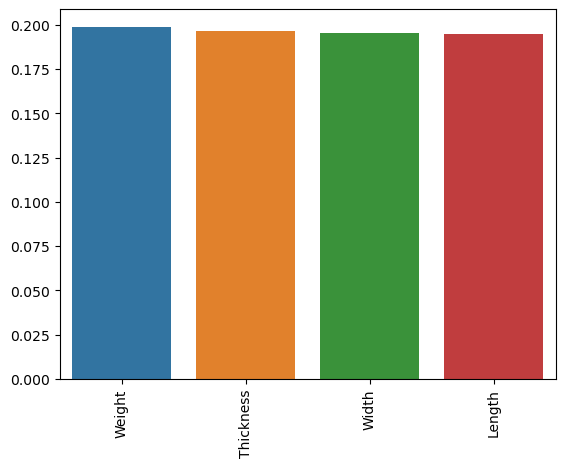

In [41]:
# Feature 중요도 Plotting
og_feature_importance = og_dt.feature_importances_
og_feature_importance_values = pd.Series(og_feature_importance, index=og_X.columns)

print("< Numeric Data 간의 중요도 >")
num_feature_descending = og_feature_importance_values.sort_values(ascending=False)[:4]
sns.barplot(x=num_feature_descending.index, y=num_feature_descending)
plt.xticks(rotation=90);

< Nominal Data 간의 중요도 >


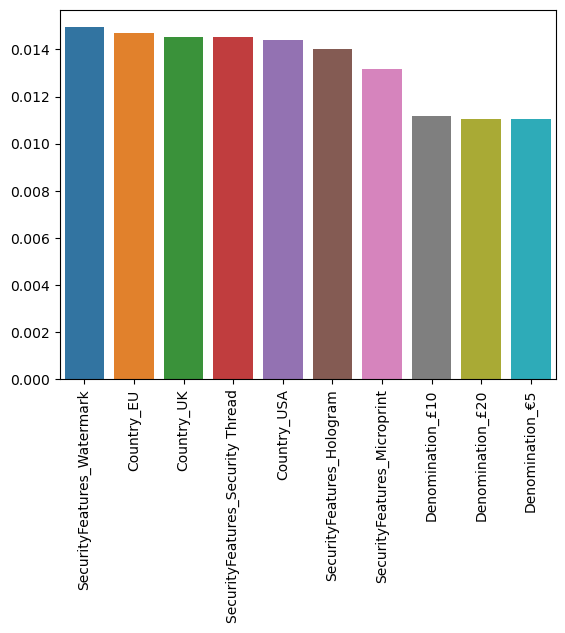

In [42]:
print("< Nominal Data 간의 중요도 >")
nom_feature_descending = og_feature_importance_values.sort_values(ascending=False)[4:14]
sns.barplot(x=nom_feature_descending.index, y=nom_feature_descending)
plt.xticks(rotation=90);

In [43]:
# 결정트리 모델 선언
fc_dt = DecisionTreeClassifier(random_state=42)

# 데이터 준비
fc_Y = fc_df['Counterfeit']
fc_X = fc_df.drop(columns=['Counterfeit'])
fc_X_train, fc_X_test, fc_Y_train, fc_Y_test = train_test_split(fc_X, fc_Y, test_size=0.3, random_state=42, stratify=fc_Y)

# Fitting
fc_dt.fit(fc_X_train, fc_Y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
# 탐색할 params 정의
params = {
  'max_depth': [3, 5, 7],
  'min_samples_split': [2, 6, 10],
}

# Grid Search 수행
grid_cv = GridSearchCV(fc_dt, param_grid=params, scoring='accuracy', cv=5)
grid_cv.fit(fc_X_train, fc_Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 6, 10]},
             scoring='accuracy')

< Numeric Data 간의 중요도 >


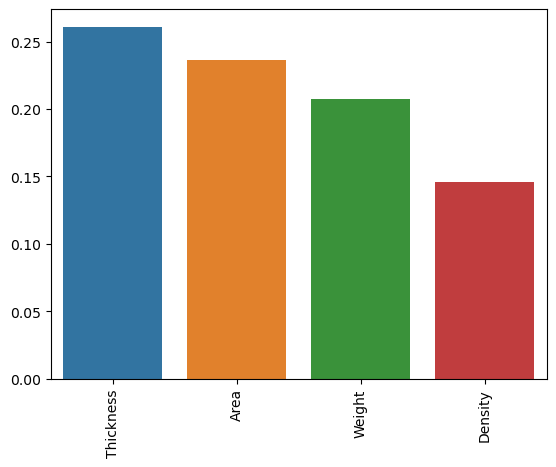

In [45]:
# Feature 중요도 Plotting
fc_feature_importance = fc_dt.feature_importances_
fc_feature_importance_values = pd.Series(fc_feature_importance, index=fc_X.columns)

print("< Numeric Data 간의 중요도 >")
num_feature_descending = fc_feature_importance_values.sort_values(ascending=False)[:4]
sns.barplot(x=num_feature_descending.index, y=num_feature_descending)
plt.xticks(rotation=90);

< Nominal Data 간의 중요도 >


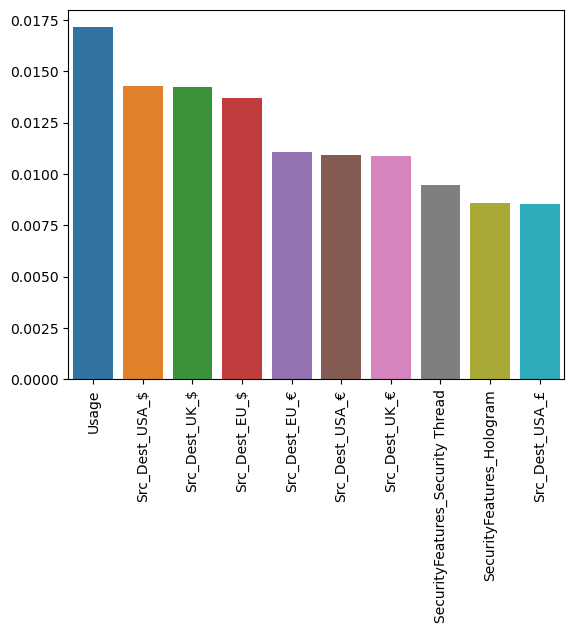

In [46]:
print("< Nominal Data 간의 중요도 >")
nom_feature_descending = fc_feature_importance_values.sort_values(ascending=False)[4:14]
sns.barplot(x=nom_feature_descending.index, y=nom_feature_descending)
plt.xticks(rotation=90);

---
### [최종 분석 결과]
##### Nominal - Nominal 분석(교차 분석) 결과, 중간 데이터셋의 Nominal feature들 중
##### Src_Dest, Usage, SecurityFeature 등의 feature들이 활용 가능성이 높다.
##### => 나머지 Nominal feature를 제거했을 때 성능 향상 기대

##### Numeric - Nominal 분석(평균 비교) 결과, 중간 데이터셋의 Numeric feature들은
##### 1. Thickness(두께) 2. Area(면적) 3. Weight(무게) 3. Density(밀도) 순으로 중요도를 가진다.
##### => 중요도에 따라 feature들을 제거해가며 성능 비교 후 최적의 데이터셋을 찾을 수 있다!

##### 'Usage' feature를 Nominal로 가정했을 때보다 좋지 못한 통계가 나오므로,
##### 해당 feature가 가지고 있는 정량적인 속성을 제거하고 Ordinal로 변환하는 작업이 가능하다.
##### => 'Usage' feature를 Ordinal에 맞게 치환하는 게 더 좋은 결과를 얻는다!